In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import os
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import clone
import json

def train_test_split_by_participant(data, test_size=0.2):
    participants = data['Participant'].unique()
    np.random.shuffle(participants)
    test_size = int(len(participants) * test_size)
    test_participants = participants[-test_size:]
    train_participants = participants[:-test_size]

    train_data = data[data['Participant'].isin(train_participants)]
    test_data = data[data['Participant'].isin(test_participants)]

    print("Training on participants from databases:\n", train_data[['Participant', 'Database']].drop_duplicates())
    print("Testing on participants from databases:\n", test_data[['Participant', 'Database']].drop_duplicates())
    return train_data, test_data

def time_series_split(data, test_ratio=0.2):
    train_data = data.groupby('Participant').apply(lambda x: x.iloc[:int(len(x)*(1-test_ratio))]).reset_index(drop=True)
    test_data = data.groupby('Participant').apply(lambda x: x.iloc[int(len(x)*(1-test_ratio)):]).reset_index(drop=True)
    return train_data, test_data

def prepare_features_labels(data, label_column, encode=True):
    features = data.drop(columns=['Participant', 'Sample', 'Sampling_Rate', 'Database', 'Gender', 'Age', 'age_binned'])
    labels = data[label_column]
    if encode:
        encoder = LabelEncoder()
        labels = encoder.fit_transform(labels)
    return features, labels

def load_data(dataset_folders):
    combined_data = []
    for folder in dataset_folders:
        for filename in os.listdir(folder):
            if filename.endswith(".csv"):
                filepath = os.path.join(folder, filename)
                participant_data = pd.read_csv(filepath)
                combined_data.append(participant_data)
    return pd.concat(combined_data, ignore_index=True)

def run_shap_analysis(model, X_train, X_test, model_name, task, selected_users, aggregate_classes=False):
    # Filter X_test for selected users
    X_test_sample = X_test.loc[X_test.index.isin(selected_users)]

    if model_name == 'Logistic Regression':
        explainer = shap.LinearExplainer(model=model, data=X_train, masker=shap.maskers.Independent(data=X_train))
        shap_values = explainer.shap_values(X_test_sample)
    elif model_name in ['Decision Tree', 'Random Forest', 'Gradient Boosting']:
        explainer = shap.TreeExplainer(model=model, data=X_train)
        shap_values = explainer.shap_values(X_test_sample, check_additivity=False)
    else:
        raise ValueError(f"Unsupported model type {model_name}")

    feature_names = X_test_sample.columns.tolist()

    if len(shap_values.shape) == 3:
        if aggregate_classes:
            aggregated_shap_values = np.mean(np.abs(shap_values), axis=2)
            plot_shap_summary(aggregated_shap_values, X_test_sample, model_name, task, feature_names=feature_names)
        else:
            for i in range(shap_values.shape[2]):
                plot_shap_summary(shap_values[:, :, i], X_test_sample, model_name, task, class_index=i, feature_names=feature_names)
    else:
        plot_shap_summary(shap_values, X_test_sample, model_name, task, feature_names=feature_names)

def plot_shap_summary(shap_values, features, model_name, task, class_index=None, feature_names=None):
    suffix = f"_class_{class_index}" if class_index is not None else ""
    
    # Adjust the figure size for better visibility
    plt.figure(figsize=(24, 8))
    shap.summary_plot(shap_values, features=features, feature_names=feature_names, plot_type="bar", show=False)
    plt.title(f'SHAP Summary Plot (Bar) - {model_name} for {task}{suffix}')
    plt.tight_layout()  # Adjust layout to prevent clipping of text
    plt.savefig(f'plot/{model_name}_{task}{suffix}_shap_summary_bar_selected.pdf')
    plt.close()

    plt.figure(figsize=(18, 8))
    shap.summary_plot(shap_values, features=features, feature_names=feature_names, show=False)
    plt.title(f'SHAP Detailed Summary Plot - {model_name} for {task}{suffix}')
    plt.tight_layout()  # Adjust layout to prevent clipping of text
    plt.savefig(f'plot/{model_name}_{task}{suffix}_shap_detailed_selected.pdf')
    plt.close()

def train_and_evaluate(model, X_train, y_train, X_test, y_test, n=1):
    best_accuracy = 0
    best_model = None
    best_predictions = None
    best_probabilities = None
    best_roc_auc = None
    for _ in range(n):
        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)
        predictions = cloned_model.predict(X_test)
        probabilities = cloned_model.predict_proba(X_test)
        accuracy = accuracy_score(y_test, predictions)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = cloned_model
            best_predictions = predictions
            best_probabilities = probabilities
    return best_model, best_accuracy, best_predictions, best_probabilities

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, task, selected_users):
    model, best_accuracy, predictions, probabilities = train_and_evaluate(model, X_train, y_train, X_test, y_test)
    print(f"Selected best model with accuracy: {best_accuracy:.4f}")
    classes = np.unique(np.concatenate([y_train, y_test]))

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    try:
        if probabilities.shape[1] == 2:
            roc_auc = roc_auc_score(y_test, probabilities[:, 1])
        else:
            y_test_bin = label_binarize(y_test, classes=classes)
            roc_auc = roc_auc_score(y_test_bin, probabilities, multi_class='ovr')
    except Exception as e:
        roc_auc = None
        print(f"ROC AUC could not be calculated: {e}")

    print("Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if roc_auc:
        print(f"ROC AUC: {roc_auc:.4f}")

    cm = confusion_matrix(y_test, predictions)
    if task == 'Participant ID':
        plt.figure(figsize=(72, 54))
    else: 
        plt.figure(figsize=(12, 9))
        
    threshold = np.percentile(cm, 0)
    mask = cm < threshold
    masked_confusion_matrix = np.where(mask, np.nan, cm)
    sns.heatmap(masked_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
    plt.title(f'Confusion Matrix for {model_name} on {task}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'plot/Confusion_Matrix_{model_name}_{task}.pdf', format='pdf')
    plt.show()

    if probabilities.shape[1] == 2:
        fpr, tpr, _ = roc_curve(y_test, probabilities[:, 1])
        plt.figure()
        plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name} on {task}')
        plt.legend(loc="lower right")
        plt.savefig(f'plot/{model_name}_{task}_ROC_Curve.pdf', format='pdf')
        plt.show()
        
    try:
        run_shap_analysis(model, X_train, X_test, model_name, task, selected_users, aggregate_classes=True)
    except Exception as e:
        print(f"SHAP analysis failed on {task} with model {model_name}")
        print(e)

def select_users(data, num_users=10, seed=42):
    np.random.seed(seed)
    selected_users = []
    datasets = data['Database'].unique()
    for dataset in datasets:
        dataset_users = data[data['Database'] == dataset]['Participant'].unique()
        age_bins = data[data['Database'] == dataset]['age_binned'].unique()
        for age_bin in age_bins:
            gender_groups = data[(data['Database'] == dataset) & (data['age_binned'] == age_bin)]['Gender'].unique()
            for gender in gender_groups:
                users = data[(data['Database'] == dataset) & (data['age_binned'] == age_bin) & (data['Gender'] == gender)]['Participant'].unique()
                if len(users) > 0:
                    selected_users.append(np.random.choice(users))
                    if len(selected_users) >= num_users:
                        return selected_users
    return selected_users

# Main experiment setup
dataset_paths = [
    'mit-bih_features/',
    'mit-long_features/',
    'smart_features/',
    'chfdb_features/',
    'brno_features/'
]

combined_data = load_data(dataset_paths)

if 'Half Minute' in combined_data.columns:
    combined_data = combined_data.drop(columns=['Half Minute'])

combined_data['Gender'] = combined_data['Gender'].replace({'m': 'M'})

combined_data = combined_data.dropna()

age_bins = [0, 18, 35, 50, 65, 80, 100]
age_labels = [f"{age_bins[i]}-{age_bins[i+1]}" for i in range(len(age_bins)-1)]

combined_data['age_binned'] = pd.cut(combined_data['Age'], bins=age_bins, labels=age_labels, right=False)
le = LabelEncoder()
combined_data['age_binned'] = le.fit_transform(combined_data['age_binned'])

train_data_id, test_data_id = time_series_split(combined_data, test_ratio=0.2)
X_train_id, y_train_id = prepare_features_labels(train_data_id, 'Participant', encode=False)
X_test_id, y_test_id = prepare_features_labels(test_data_id, 'Participant', encode=False)

X_train_id['Participant'] = train_data_id['Participant']
X_test_id['Participant'] = test_data_id['Participant']
X_train_id.set_index('Participant', inplace=True)
X_test_id.set_index('Participant', inplace=True)
print("\n--- Participant ID Identification ---")

selected_users = select_users(test_data_id, num_users=10)
print(f"Selected Users: {selected_users}")
print(test_data_id[test_data_id['Participant'].isin(selected_users)][['Participant', 'Database', 'Age', 'Gender', 'age_binned']].drop_duplicates())

with open('selected_users.json', 'w') as f:
    json.dump(selected_users, f)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    # 'Gradient Boosting': GradientBoostingClassifier()
}

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- Participant ID Identification ---
Selected Users: ['brno_08', 'brno_05', 'brno_02', 'brno_04', 'brno_10', 'brno_12', 'brno_15', 'chfdb_14', 'chfdb_12', 'chfdb_06']
     Participant Database   Age Gender  age_binned
72       brno_02     brno  58.0      M           2
144      brno_04     brno  43.0      F           1
216      brno_05     brno  21.0      M           0
410      brno_08     brno  24.0      F           0
554      brno_10     brno  44.0      M           1
698      brno_12     brno  70.0      M           3
842      brno_15     brno  83.0      F           4
1344    chfdb_06    chfdb  22.0      M           0
1704    chfdb_12    chfdb  61.0      M           2
1848    chfdb_14    chfdb  63.0      F           2


/tmp/ipykernel_929855/2171370265.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data = data.groupby('Participant').apply(lambda x: x.iloc[:int(len(x)*(1-test_ratio))]).reset_index(drop=True)
/tmp/ipykernel_929855/2171370265.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_data = data.groupby('Participant').apply(lambda x: x.iloc[int(len(x)*(1-test_ratio)):]).reset_index(drop=True)


In [2]:
X_test_id

,P_minus_R_amp_mean,Q_minus_R_amp_mean,S_minus_R_amp_mean,T_minus_R_amp_mean,PQ_interval_mean,QR_interval_mean,RS_interval_mean,ST_interval_mean
Participant,,,,,,,,
brno_01,-1.141249,-1.324783,-1.299768,-1.148128,0.170458,0.038500,0.075458,0.210292
brno_01,-1.139667,-1.322945,-1.298502,-1.147751,0.170174,0.039348,0.075826,0.207609
brno_01,-1.107483,-1.343764,-1.332647,-0.997635,0.157478,0.057375,0.077667,0.200000
brno_01,-1.152959,-1.323557,-1.297404,-1.141717,0.171087,0.038435,0.077000,0.207174
brno_01,-1.141500,-1.323596,-1.296803,-1.153769,0.172958,0.039625,0.076958,0.206042
...,...,...,...,...,...,...,...,...
smart_99,-0.023178,-0.408367,-0.575172,-0.049246,0.170313,0.034375,0.033984,0.158203
smart_99,-0.083903,-0.271396,-0.486075,-0.067961,0.196484,0.026172,0.039844,0.151562
smart_99,-0.046202,-0.374836,-0.554408,-0.027545,0.181726,0.048573,0.031929,0.206522



Model: Logistic Regression
Selected best model with accuracy: 0.5425


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics:
Accuracy: 0.5425
Precision: 0.5268
Recall: 0.5425
F1-Score: 0.5017
ROC AUC: 0.9763


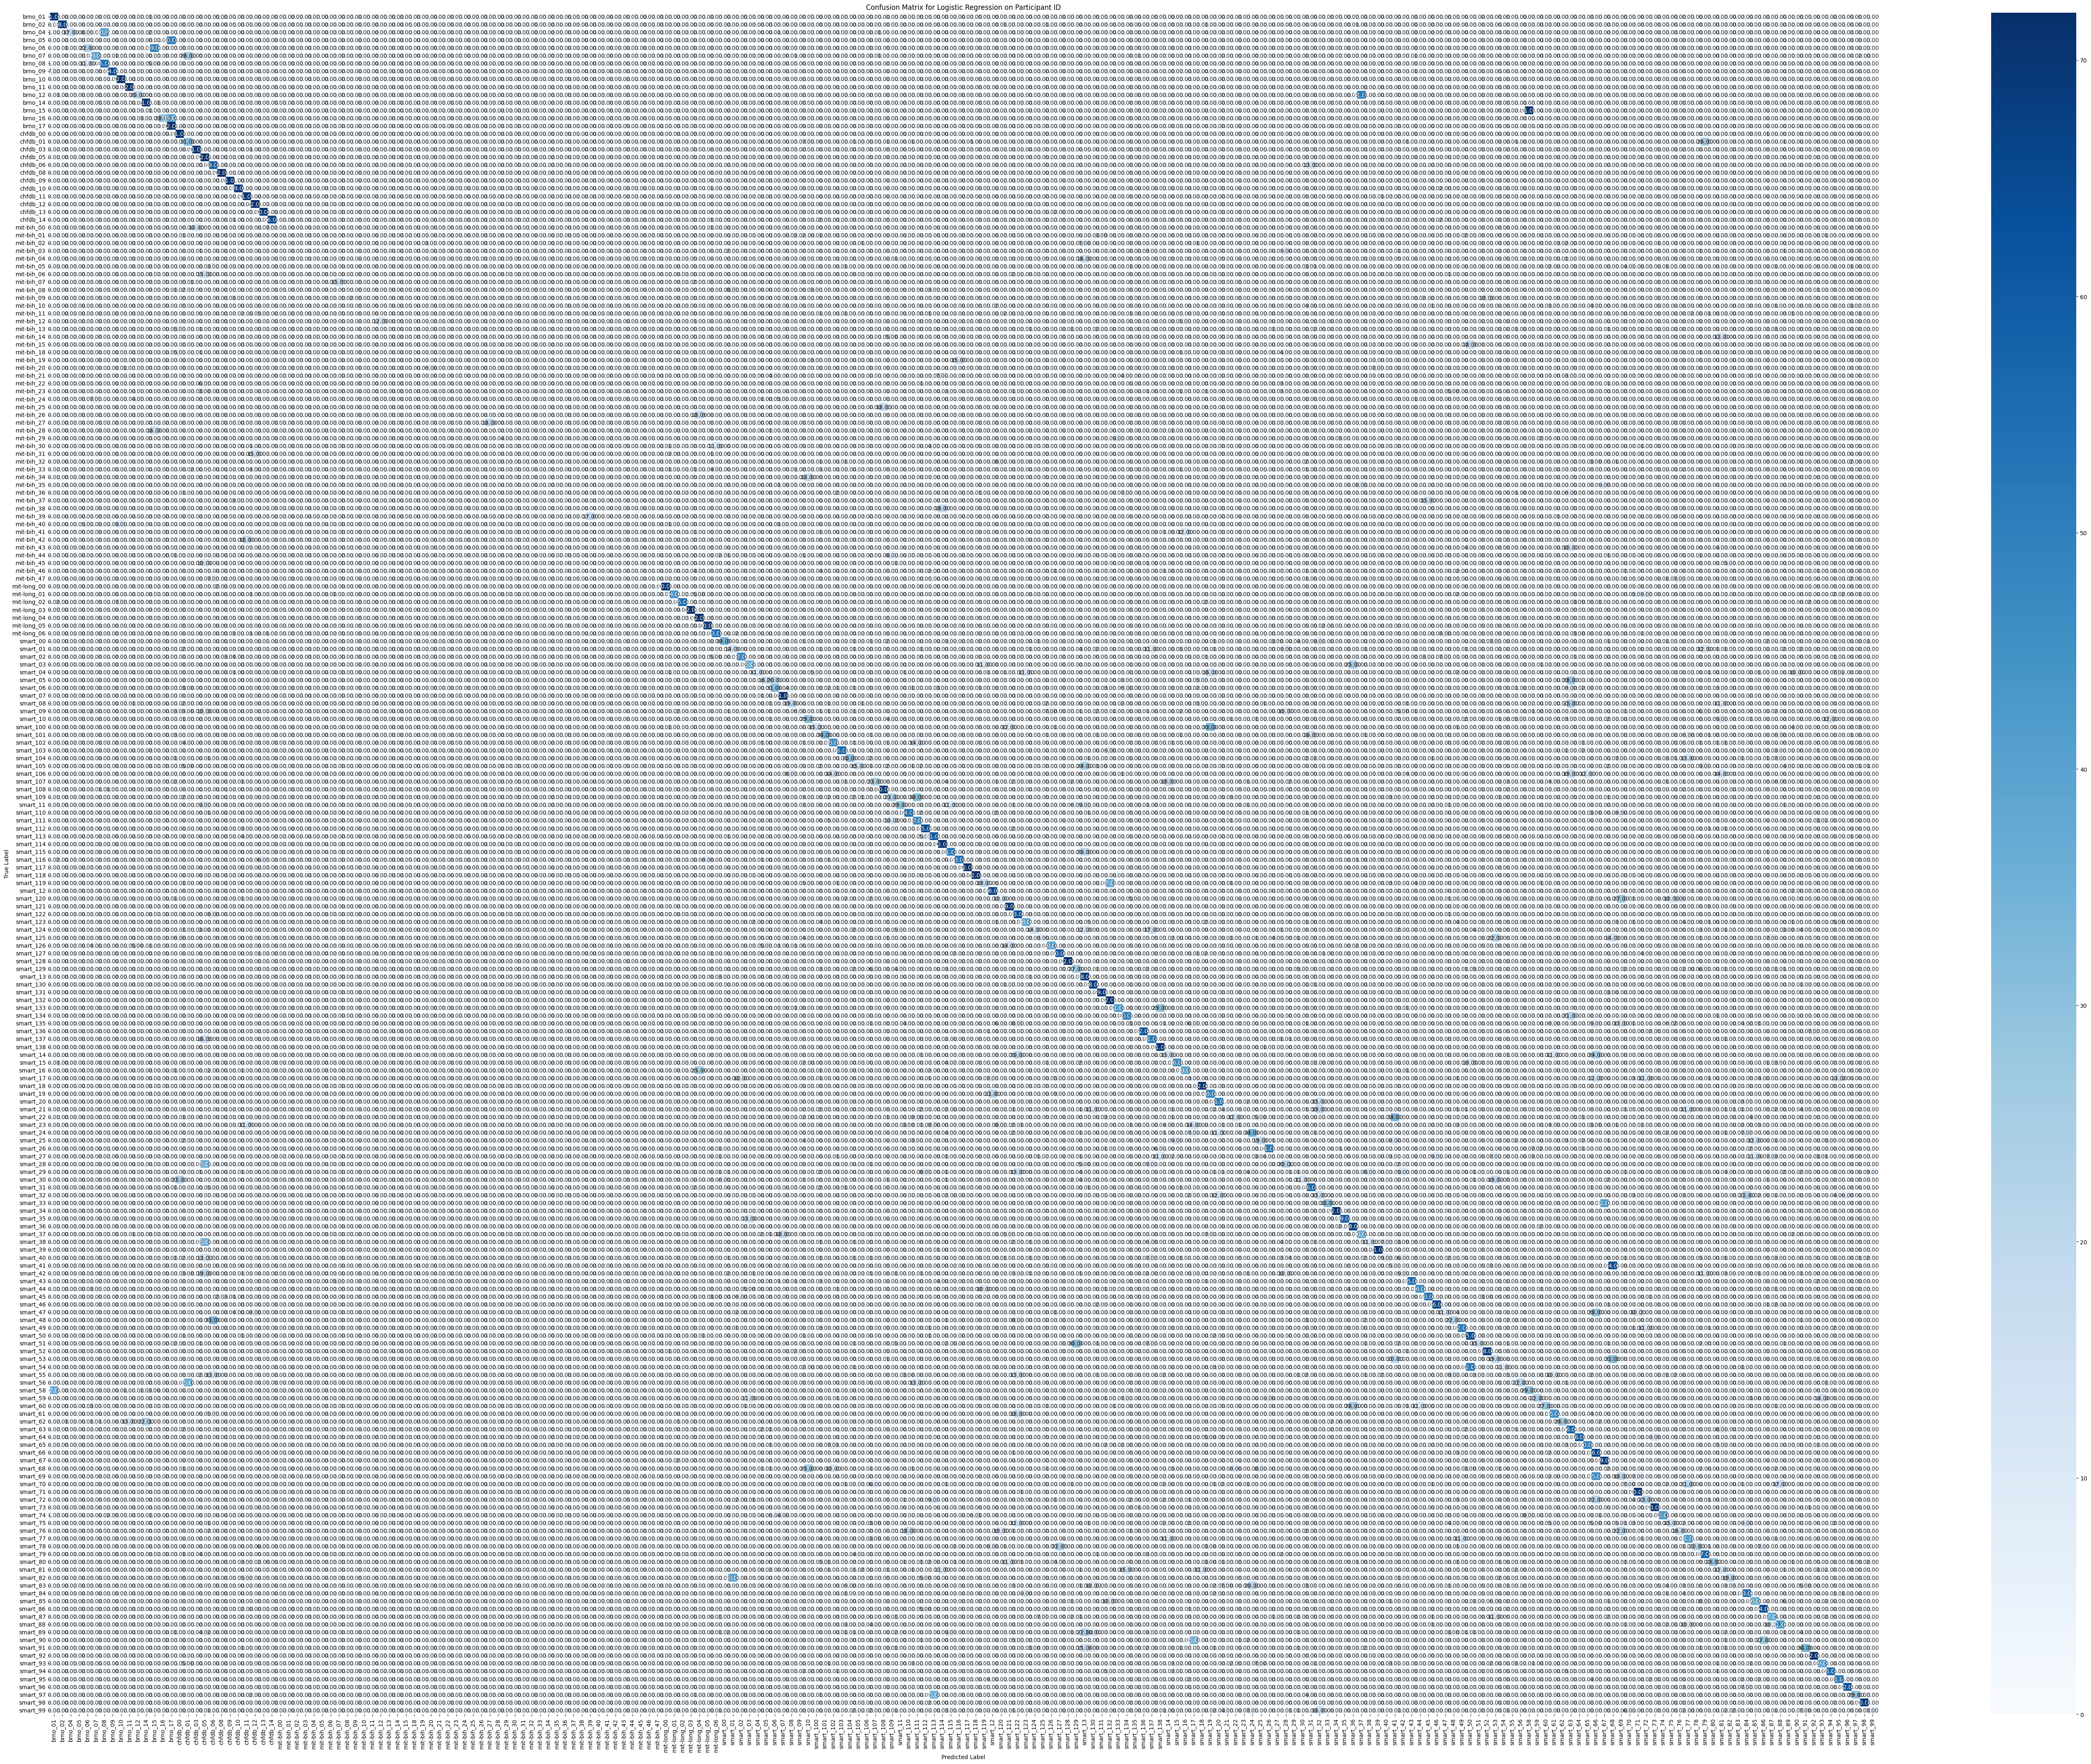


Model: Decision Tree
Selected best model with accuracy: 0.6734
Metrics:
Accuracy: 0.6734
Precision: 0.6794
Recall: 0.6734
F1-Score: 0.6680
ROC AUC: 0.8310


In [3]:
for name, model in models.items():
    print(f"\nModel: {name}")
    evaluate_model(model, X_train_id, y_train_id, X_test_id, y_test_id, model_name=name, task='Participant ID', selected_users=selected_users)
